# Key notebook with examples of code for maintaining the cureated set of histones
- spcific manupulations can be done in copies of this notebook.

In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import warnings
warnings.filterwarnings("ignore")

In [59]:
from curated_set_services import CuratedSet
from curated_set_services import show_msa_jl, dict2tree, muscle_p2p_aln
from pynucl.hist_features import hist_shf4seq, hist_features
from Bio.Align.AlignInfo import SummaryInfo
from Bio import AlignIO
from pytexshade import ipyshade
from ete3 import Tree, TreeStyle
import json
from BCBio import GFF
!mkdir -p tmp

In [7]:
#Load data from histones.csv
curated_set = CuratedSet()
cs=curated_set

In [8]:
#Access pandas dataframe with the histones information
#cs.data
cs.data.head()

accession type  variant_group        variant doublet  \
XP_011215280.1  XP_011215280.1  H2A  canonical_H2A  canonical_H2A           
XP_011216221.1  XP_011216221.1  H2B  canonical_H2B  canonical_H2B           
XP_011215272.1  XP_011215272.1  H2A          H2A.B          H2A.B           
XP_002927211.2  XP_002927211.2  H2A          H2A.L          H2A.L           
XP_002913536.1  XP_002913536.1  H2A          H2A.P          H2A.P           

                       gi geneid taxonomyid                organism    phylum  \
XP_011215280.1  752439274              9646  Ailuropoda melanoleuca  Chordata   
XP_011216221.1  752441783              9646  Ailuropoda melanoleuca  Chordata   
XP_011215272.1  752439251              9646  Ailuropoda melanoleuca  Chordata   
XP_002927211.2  301783589              9646  Ailuropoda melanoleuca  Chordata   
XP_002913536.1  301755368              9646  Ailuropoda melanoleuca  Chordata   

                   class info references  \
XP_011215280.1  Mammalia                   
XP_011216221.1  Mammalia                   
XP_011215272.1  Mammalia                   
XP_002927211.2  Mammalia                   
XP_002913536.1  Mammalia                   

                                                         sequence  
XP_011215280.1  MSGRGKQGGKARAKAKSRSSRAGLQFPVGRVHRLLRKGNYAERVGA...  
XP_011216221.1  MPDPAKSAPAPKKGSKKAVTKVQKKDGKKRKRSRKESYSVYVYKVL...  
XP_011215272.1  MPGDRSRRGSSSGQRRTRSRTARAELSFSVSHVERLLREGHYAQRL...  
XP_002927211.2  MSGRRSPWHSHQHKRHGLSRSMRAELQFPVSRVDRLLREGCYAQRL...  
XP_002913536.1  MSGKKSHESSYQTQAHLITTELQVPVSYVDRLLQENQYNHPLSSST...

## Subsetting and accessing data about histones

In [9]:
#cs.data.accession
#cs.data['accession']
# cs.data[cs.data.type == 'H2A']
# cs.data[(cs.data['type'] == 'H2A') & (cs.data['class'] == 'Mammalia')]
cs.data.query('type == "H2A" & `class`=="Mammalia" & variant.str.contains("H2A.Z")', engine='python')['accession']

NP_002097.1    NP_002097.1
NP_036544.1    NP_036544.1
NP_619541.1    NP_619541.1
NP_958844.1    NP_958844.1
NP_958924.1    NP_958924.1
NP_958925.1    NP_958925.1
Name: accession, dtype: object

## Technical maintenance of the list

In [11]:
# Identifying duplicated accessions
list(cs.has_duplicates())

[]

In [ ]:
# check with NCBI if accesssions have new versions and update them. E.g. NP_12345.1 has now NP_12345.2.
from Bio import Entrez
Entrez.email = 'histoneDB@intbio.org'
cs.update_accession_version()

Unexpected error: <class 'KeyboardInterrupt'>, Retrying, attempt 0
Unexpected error: <class 'KeyboardInterrupt'>, Retrying, attempt 1
Unexpected error: <class 'KeyboardInterrupt'>, Retrying, attempt 2
Unexpected error: <class 'KeyboardInterrupt'>, Retrying, attempt 3
Unexpected error: <class 'KeyboardInterrupt'>, Retrying, attempt 4


In [ ]:
#Fetch and update taxids and taxonomic data from NCBI by accessions
curated_set.update_taxids() #update only for blank data use blank_data=True, update for specific accessions use accessions=[<list of accessions>]

In [6]:
#Update sequences
curated_set.update_sequence() #update only for blank data use blank_data=True

Fetching 413 seqs
Sequence for XP_002927211.2 changes from MSGRRSPWHSHQHKRHGLSRSMRAELQFPVSRVDRLLREGCYAQRLSSSTPVFLTGVLEYLTANILELAGQEARNHHKMRITPEHVQRALVNNQHLSCLFEDITSLPAKGAPRLRKC to MSGRRSPWHSHQHKRHGLSRSMRAELQFPVSRVDRLLREGCYAQRLSSSTPVFLTGVLEYLTANILELAGQEARNHHKMRITPEHVQRALVNNQHLSCLFEDITSPPAKGTPQLRKC
Sequence for XP_002763866.2 changes from MSERRSRRGSSAAGRRGHTRSRTARAELIFSVSKMERGLWEGHYAQRLSDNAPVYLAAVIQYLTAKILELAAKEADNRGERIITPRLLDMAVHNDGLLSTLFHAITISQVGPGPN to MSERRSRRGSSAAGRRGHTRSRTARAELIFSVSKMERGLWEGHYAQRLSDNAPVYLAAVIQYLTAKILELAAKGADNRGERIITPRLLDMAVHNDGLLSTLFHAITISQVGPGPN
Sequence for XP_001504072.2 changes from MARASTKKSRCSRRRQSPASRKKSHASTYRGHRNYSLYINRVLKEVVPQRGISARTLDTMNILINNIFERISTEACSMMYFRNRCTLTPQDVQKAVYSLFPGKLAKYAVAFGSEAVQRYLHS to MARDSTKKSRCSRRRQSPASRKKSHASTYRGHRNYSLYINRVLKEVVPQRGISARTLDTMNILINNIFERISTEACSMMYFRNRCTLTPQDVQKAVYSLFPGKLAKYAVAFGSEAVQRYLHS
Sequence for XP_012928609.2 changes from MSGRGKGGKGLGKGGAKRHRKVLRDNIQGITKPAIRRLARRGGVKRISGLIYEETRGVLKVFLENVIRDAVTYTEHAKRKTVTAMDVVYALKRQG

In [ ]:
cs.save() #cs.save(filename='<filename>')

## Multiple Sequence Alignment, trimming, visualization

In [7]:
#Make algnment with Muscle
msa=cs.muscle_aln(cs.data.query('type == "H2A" & variant.str.contains("H2A.Z") & `class`=="Mammalia"', engine='python')['accession'],options=["-maxiters","16","-gapopen","-20"],debug=False)

In [9]:
#View MSA inline in jupyterlab with jupyterlab-fasta extension, otherwise will just print it.
show_msa_jl(msa)

>H2A.Z_Homo_sapiens_NP_002097.1 NP_002097.1 histone: H2A variant: H2A.Z organism: Homo sapiens
MAGGKAGKDSGKAKTKAVSRSQRAGLQFPVGRIHRHLKSRTTSHGRVGATAAVYSAAILE
YLTAEVLELAGNASKDLKVKRITPRHLQLAIRGDEELDSLIKATIAGGGVIPHIHKSLIG
KKGQQKTV
>H2A.Z_Homo_sapiens_NP_958844.1 NP_958844.1 histone: H2A variant: H2A.Z organism: Homo sapiens
--------------------------MFPVGRIHRHLKTRTTSHGRVGATAAVYSAAILE
YLTAEVLELAGNASKDLKVKRITPRHLQLAIRGDEELDSLIKATIAGGGVIPHIHKSLIG
KKGQQKTA
>H2A.Z_Homo_sapiens_NP_619541.1 NP_619541.1 histone: H2A variant: H2A.Z organism: Homo sapiens
MAGGKAGKDSGKAKAKAVSRSQRAGLQFPVGRIHRHLKTRTTSHGRVGATAAVYSAAILE
YLTAEVLELAGNASKDLKVKRITPRHLQLAIRGDEELDSLIKATIAGGEKRRCS------
--------
>H2A.Z_Homo_sapiens_NP_958925.1 NP_958925.1 histone: H2A variant: H2A.Z organism: Homo sapiens
MAGGKAGKDSGKAKAKAVSRSQRAGLQ---------------------------------
-----VLELAGNASKDLKVKRITPRHLQLAIRGDEELDSLIKATIAGGGVIPHIHKSLIG
KKGQQKTA
>H2A.Z_Homo_sapiens_NP_036544.1 NP_036544.1 histone: H2A variant: H2A.Z organism: Homo sapiens
M

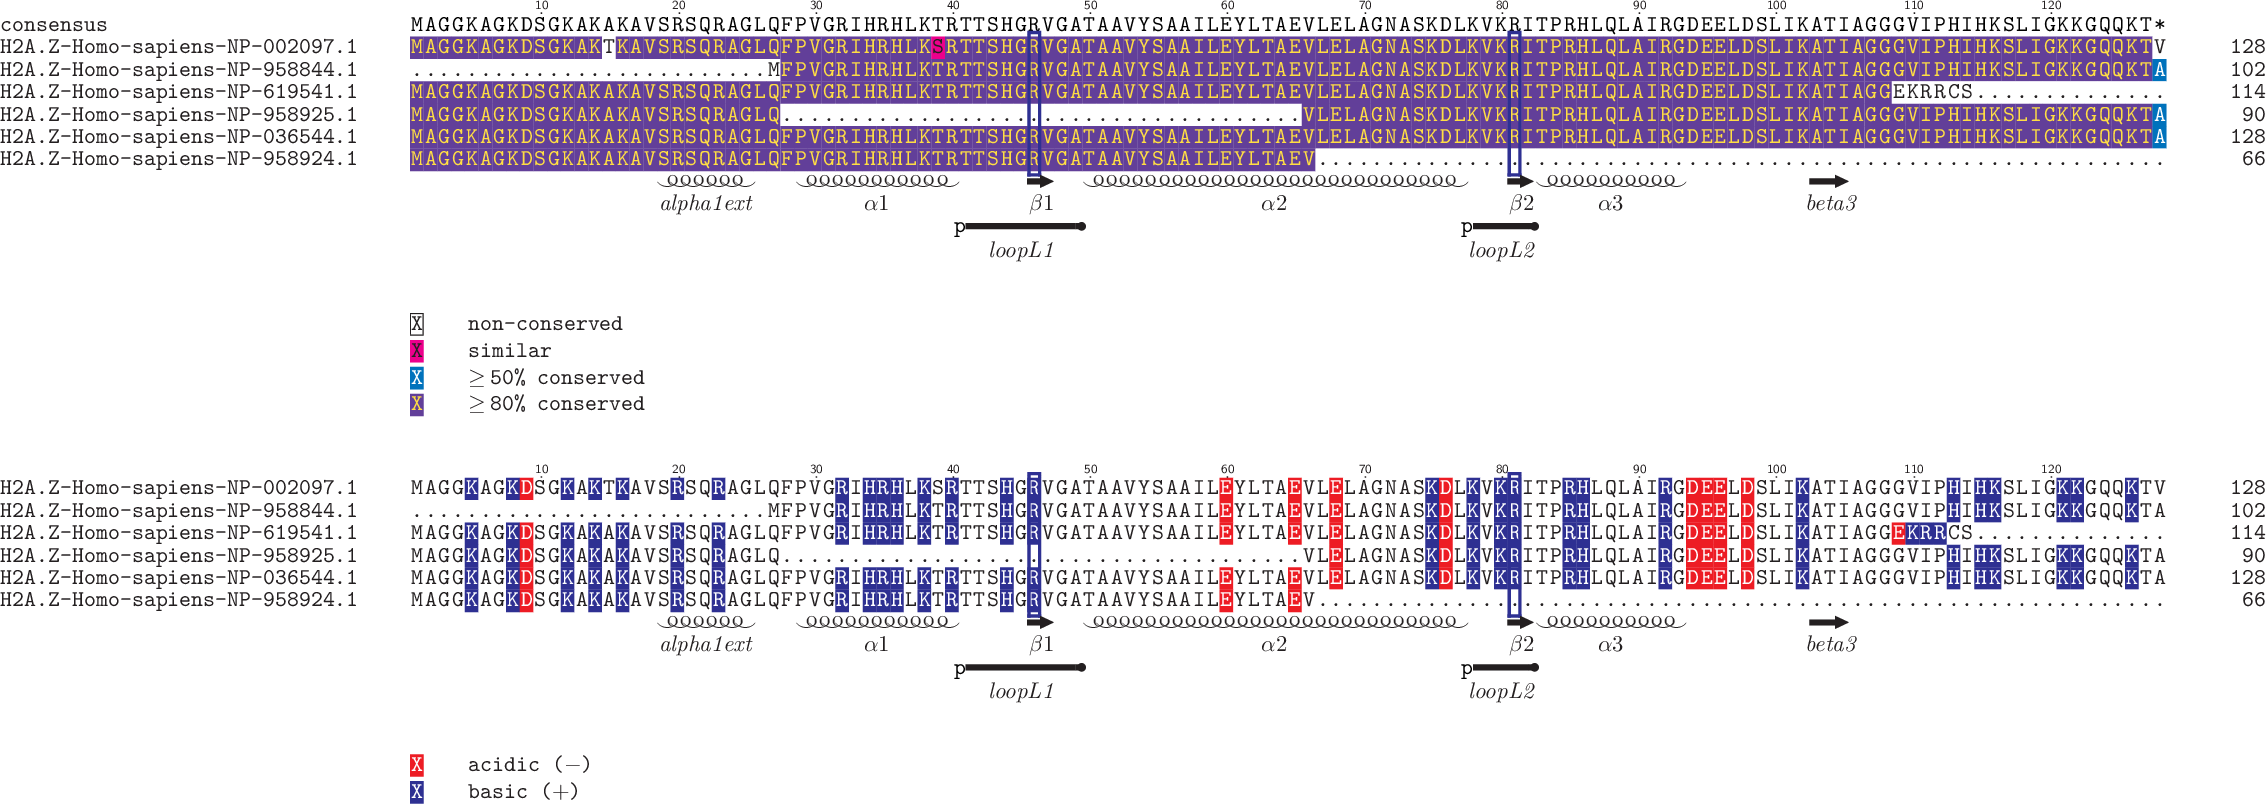

In [10]:
#via pytexshade, see function options here https://github.com/intbio/pytexshade/blob/3b4620c95f6607fffc06063f582bdb294d68fc09/pytexshade/shade.py#L134
ipyshade.shadedmsa(msa,shading_modes=['similar','charge_functional'],ruler=True,features=hist_shf4seq(SummaryInfo(msa).dumb_consensus(threshold=0.1,ambiguous='X')))

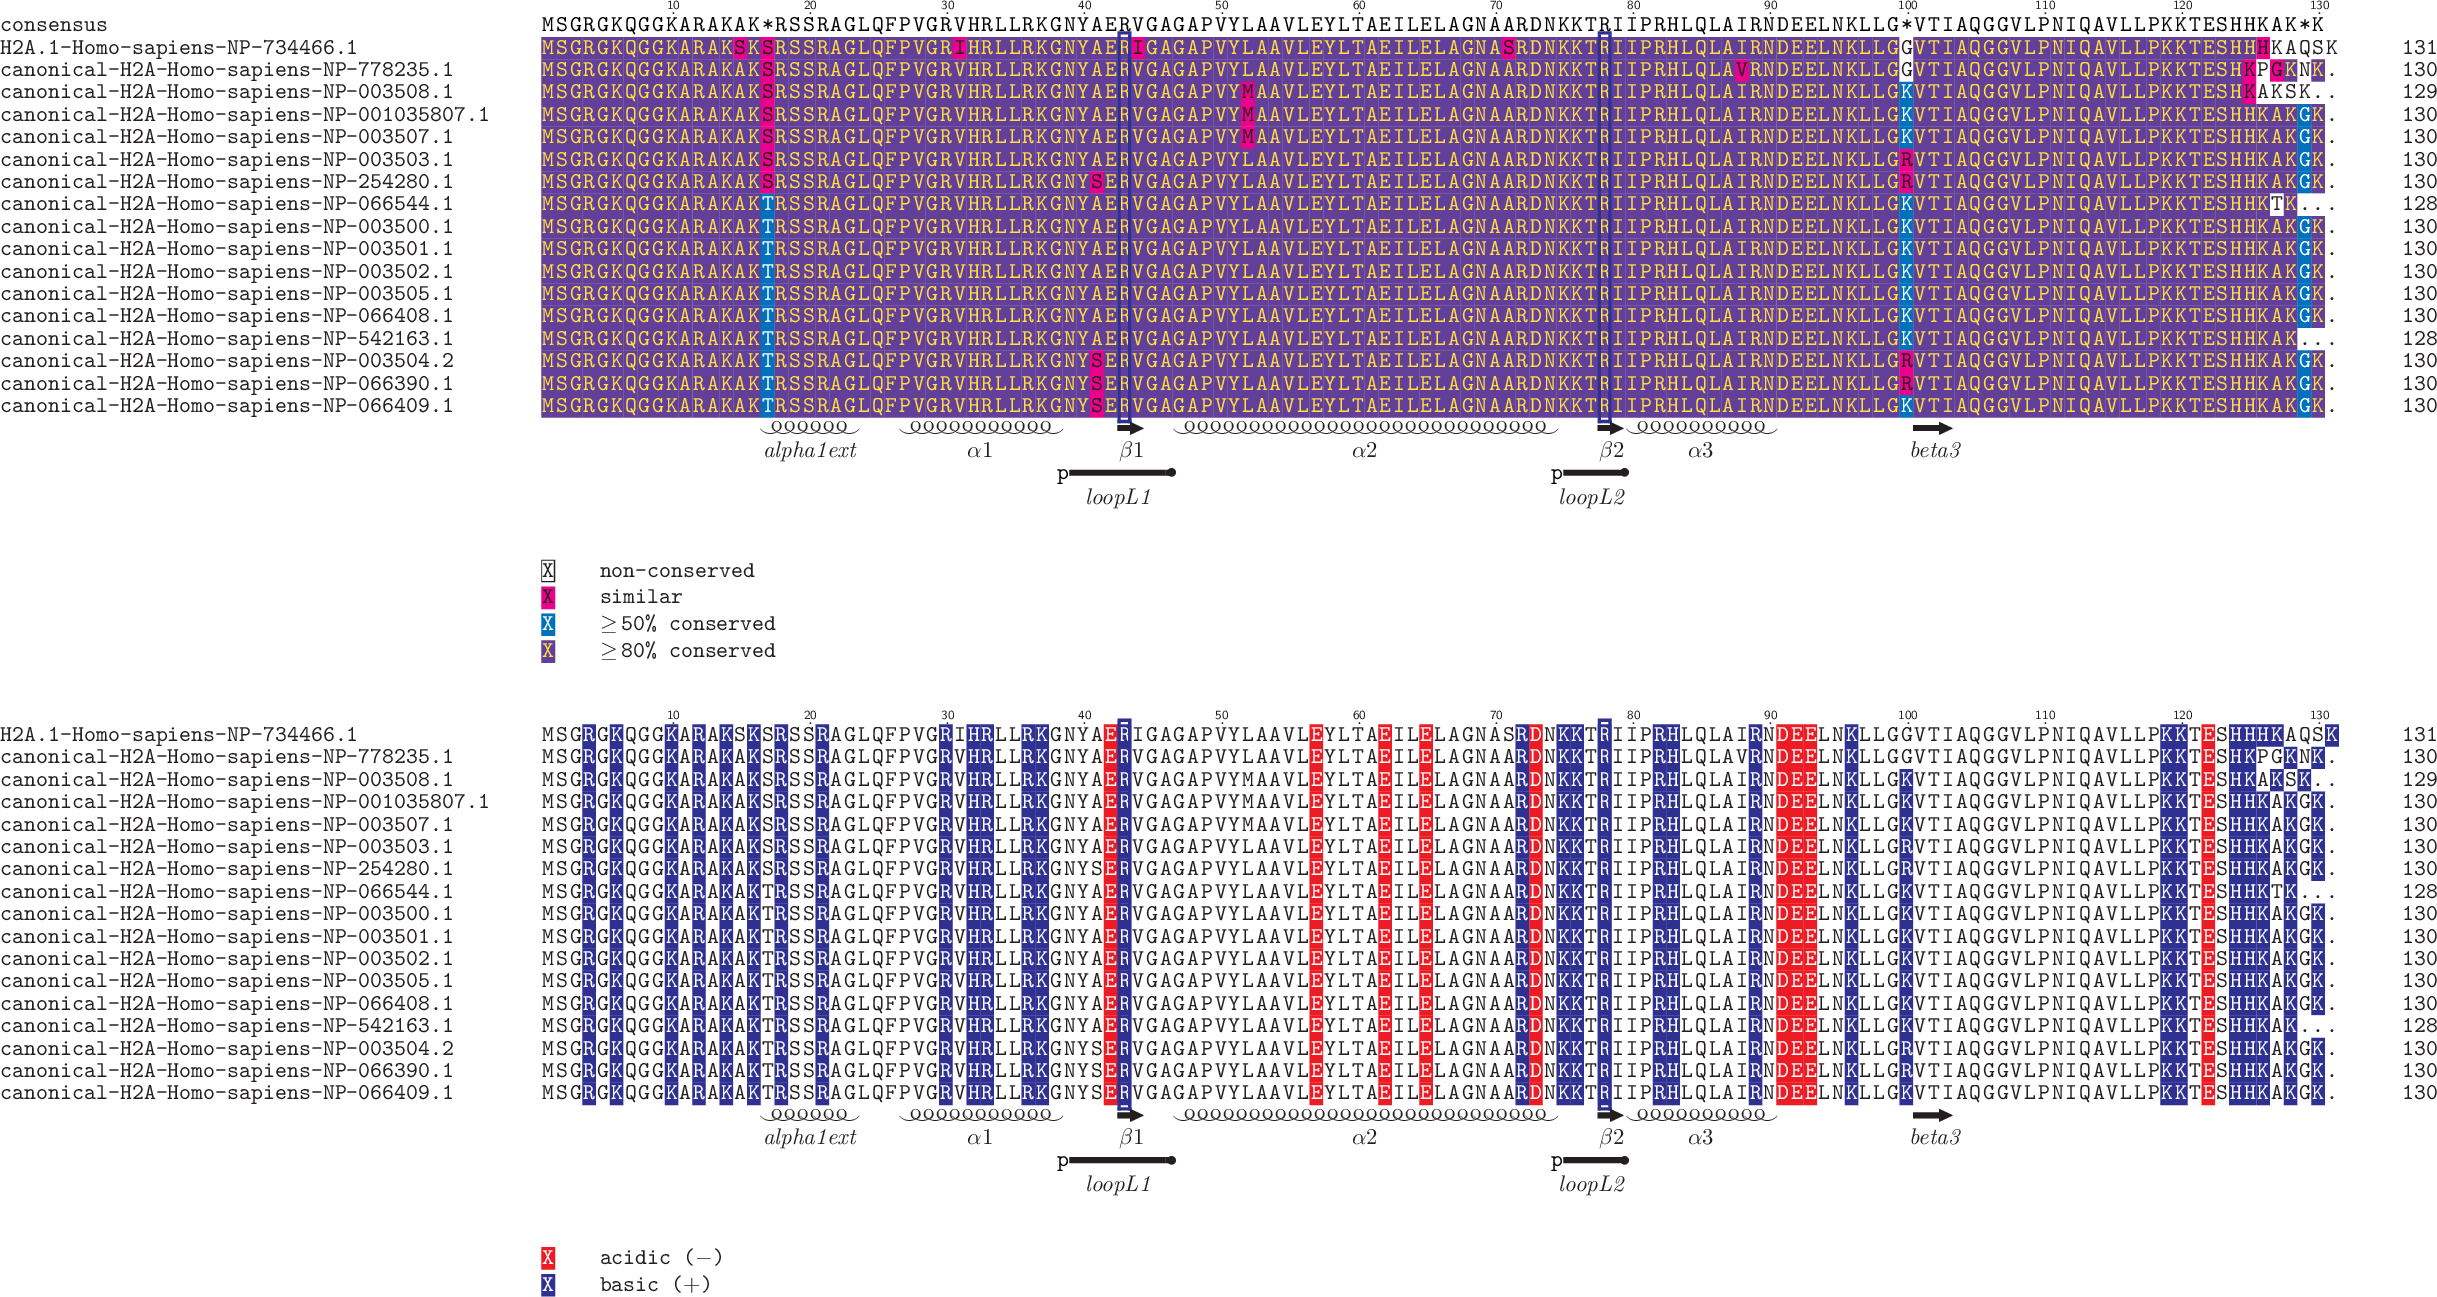

In [55]:
msa=cs.muscle_aln(cs.data.query('type == "H2A" & (variant=="canonical_H2A" | variant=="H2A.1") & organism=="Homo sapiens"', engine='python')['accession'],options=["-maxiters","16","-gapopen","-20"],debug=False)
ipyshade.shadedmsa(msa,shading_modes=['similar','charge_functional'],ruler=True,features=hist_shf4seq(SummaryInfo(msa).dumb_consensus(threshold=0.1,ambiguous='X')))

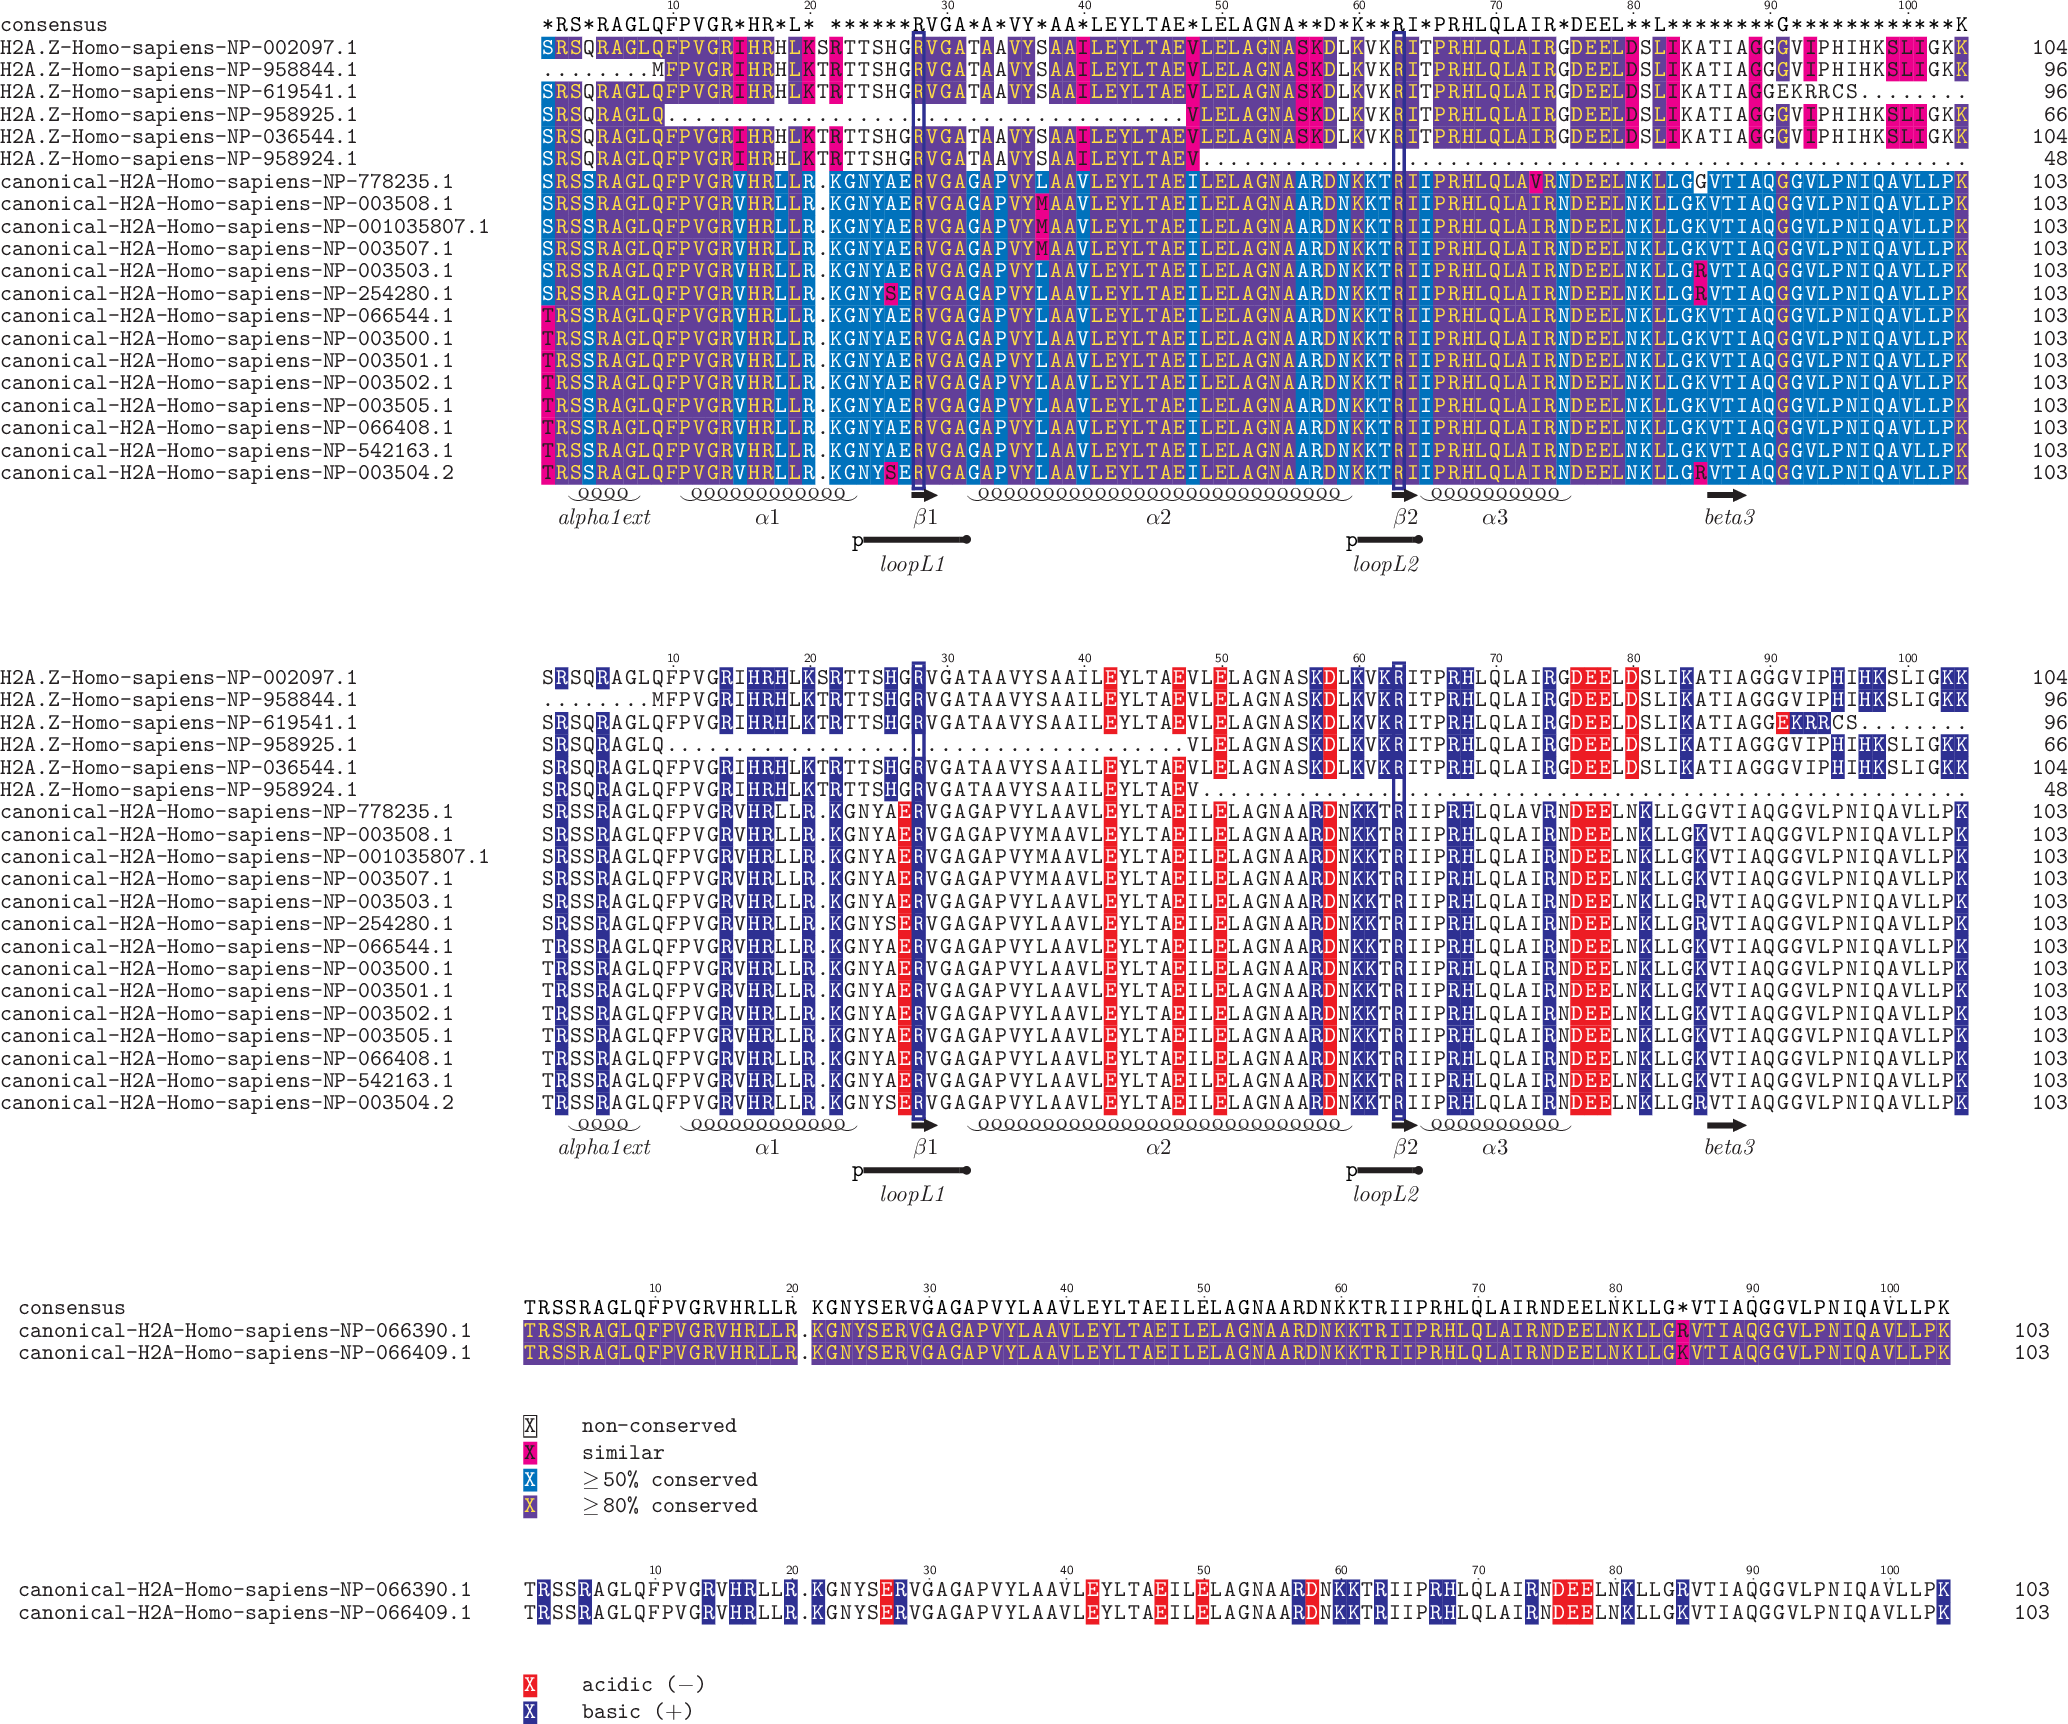

In [188]:
#trim alignment to histone core
core=hist_features(SummaryInfo(msa).dumb_consensus(threshold=0.1,ambiguous='X'))[1]
msa_core=msa[:,core.location.start:core.location.end]
ipyshade.shadedmsa(msa_core,shading_modes=['similar','charge_functional'],ruler=True,features=hist_shf4seq(SummaryInfo(msa_core).dumb_consensus(threshold=0.1,ambiguous='X')))

## Phylogenetic trees using FastTree
#intro to phylogenetics https://www.ebi.ac.uk/training/online/courses/introduction-to-phylogenetics/what-is-a-phylogeny/aspects-of-phylogenies/branches/



In [122]:
msa=cs.muscle_aln(cs.data.query('type == "H2A" & variant=="H2A.Z" & `class`=="Mammalia"', engine='python')['accession'],debug=False)

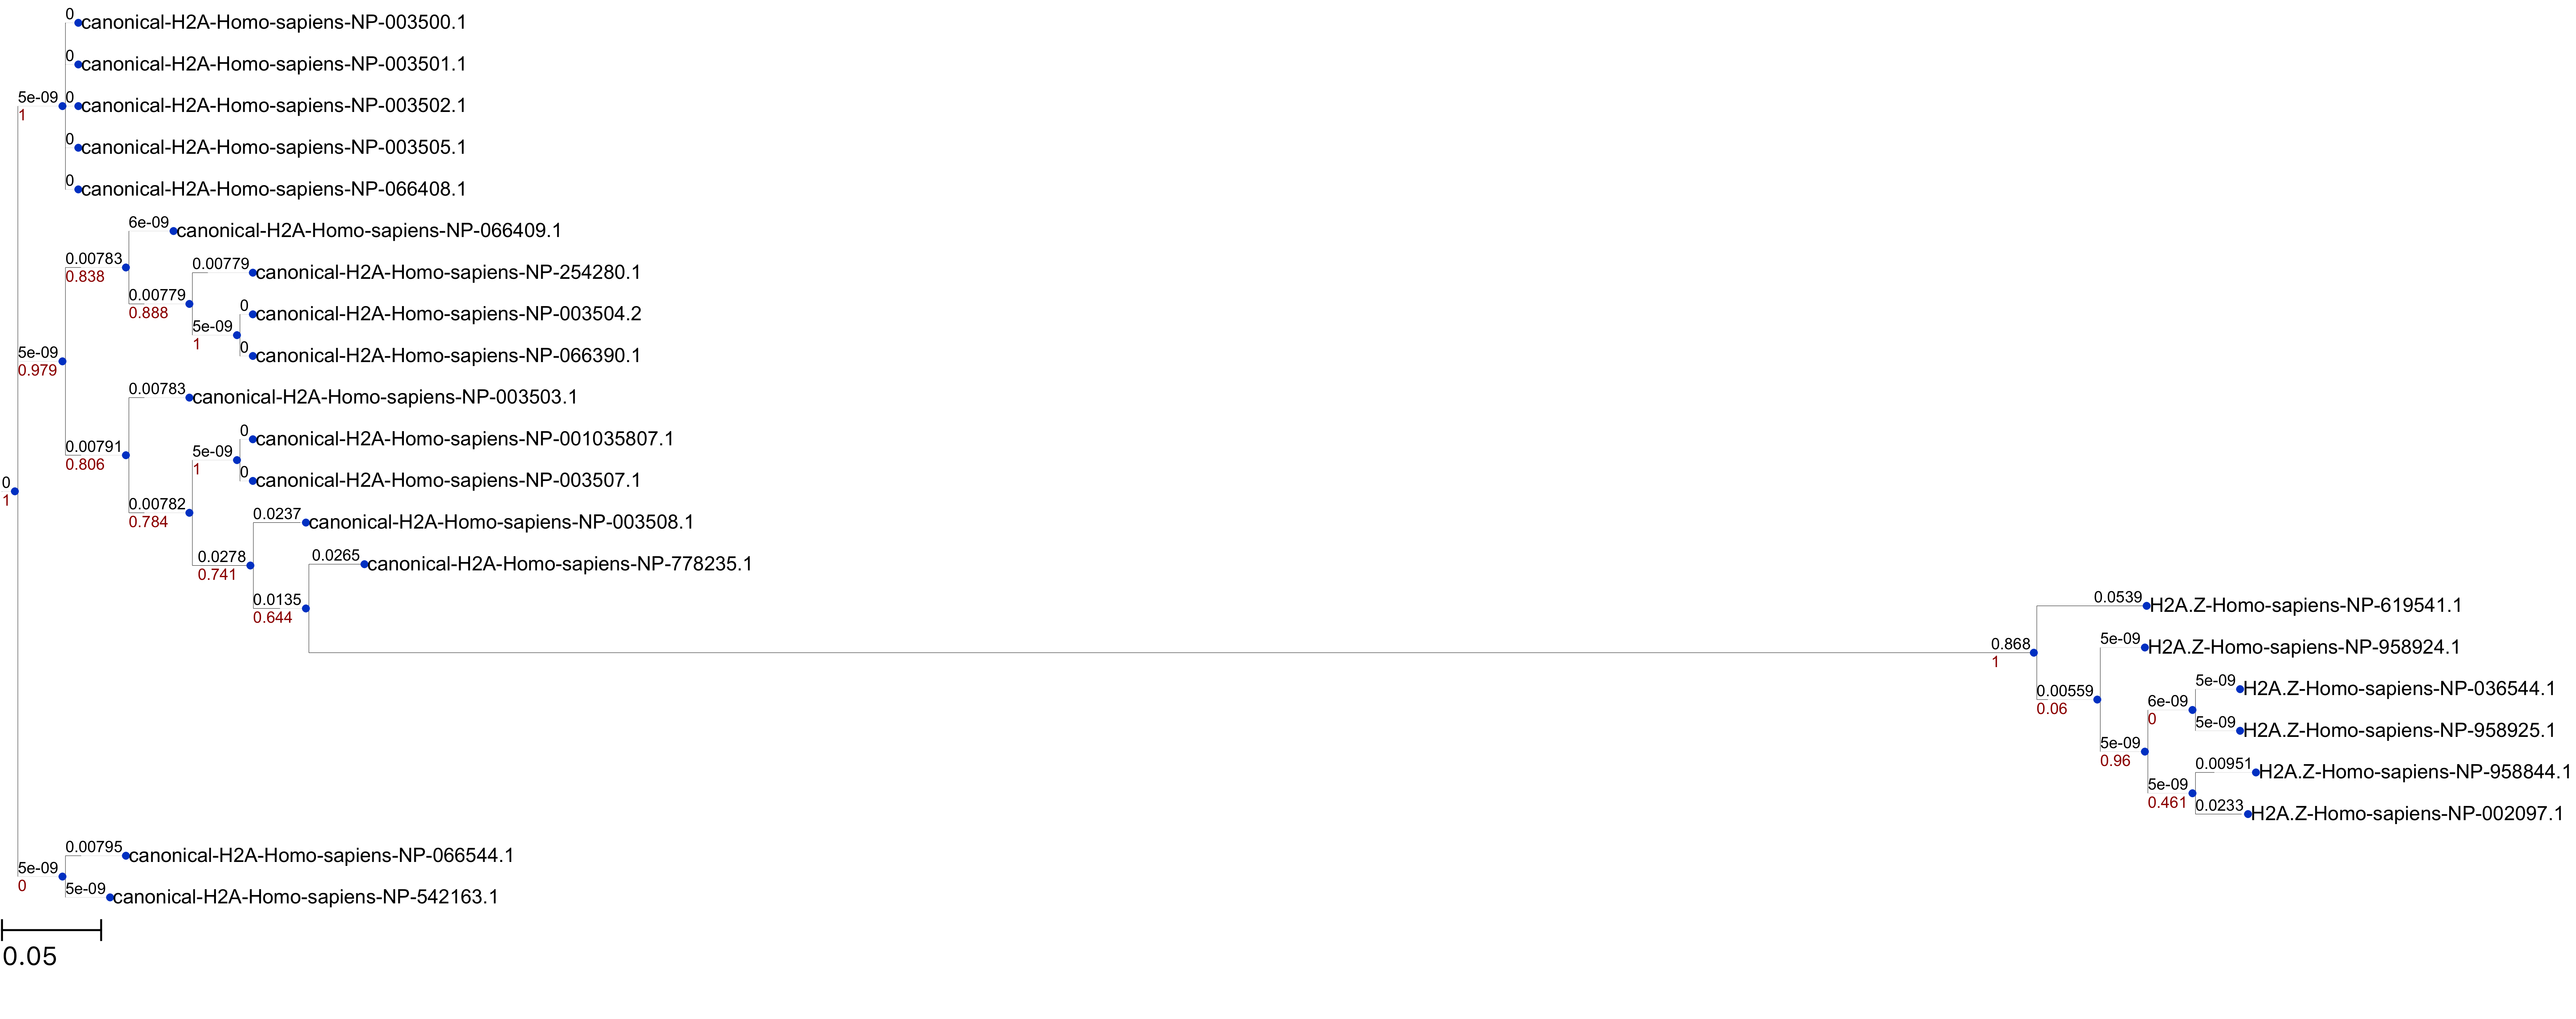

In [165]:
#info about drawing trees http://etetoolkit.org/docs/latest/tutorial/tutorial_drawing.html
!printf "{msa.format('fasta')}" | FastTree > tmp/tree_file 2> /dev/null
t = Tree("tmp/tree_file")
ts = TreeStyle()
# style.mode = "c" # draw tree in circular mode
ts.scale = 1000
ts.show_leaf_name = True
ts.show_branch_length = True
ts.show_branch_support = True
t.render("%%inline", w=2000, units="mm", tree_style=ts)

## Loading and manupilating classification.json
Using it to select subvariants

In [11]:
with open('classification.json') as json_file:
    data = json.load(json_file)

In [12]:
hist_tree=Tree()
dict2tree(hist_tree,data['tree'])
print(hist_tree.get_ascii(show_internal=True))


      /-H2A.Z
     |
   /H2A-H2A.B
  |  |
  |   \-macroH2A
  |
  |--H2B
  |
  |                /-cH3.1_(Metazoa?)
  |   /cH3_(Metazoa)
  |  |             \-cH3.2_(Metazoa?)
  |  |
  |  |--cH3_(Plants)
  |  |
  |  |--cenH3_(Eukarya)
  |  |
  |  |--H3.3_(Eukarya)
  |  |
  |  |--H3.5_(Mammals?)
--|  |
  |-H3--H3.5_(Hominids?)
  |  |
  |  |--H3.Y_(Primates?)
  |  |
  |  |--H3.P_(Moneuplotes?)
  |  |
  |  |--H3.V_(Trypanosomes?)
  |  |
  |  |--H3.B_(Giardia?)
  |  |
  |  |--H3_(Viruses)
  |  |
  |   \-H3_unclassified
  |
  |--H4
  |
   \-Archaeal


In [13]:
#Selection all sequences for an internal node variant
ss='variant.str.contains("Nonsense")'
for node in hist_tree.search_nodes(name='H2A.Z')[0].traverse():
    ss=ss+f' | variant.str.contains("{node.name}")'
print(ss)

cs.data.query(f'{ss} & `class`=="Mammalia"', engine='python')



variant.str.contains("Nonsense") | variant.str.contains("H2A.Z")


accession type variant_group variant doublet        gi geneid  \
NP_002097.1  NP_002097.1  H2A         H2A.Z   H2A.Z           4504255          
NP_036544.1  NP_036544.1  H2A         H2A.Z   H2A.Z           6912616          
NP_619541.1  NP_619541.1  H2A         H2A.Z   H2A.Z          20357599          
NP_958844.1  NP_958844.1  H2A         H2A.Z   H2A.Z          41406067          
NP_958924.1  NP_958924.1  H2A         H2A.Z   H2A.Z          41406069          
NP_958925.1  NP_958925.1  H2A         H2A.Z   H2A.Z          41406071          

            taxonomyid      organism    phylum     class info references  \
NP_002097.1       9606  Homo sapiens  Chordata  Mammalia                   
NP_036544.1       9606  Homo sapiens  Chordata  Mammalia                   
NP_619541.1       9606  Homo sapiens  Chordata  Mammalia                   
NP_958844.1       9606  Homo sapiens  Chordata  Mammalia                   
NP_958924.1       9606  Homo sapiens  Chordata  Mammalia                   
NP_958925.1       9606  Homo sapiens  Chordata  Mammalia                   

                                                      sequence  
NP_002097.1  MAGGKAGKDSGKAKTKAVSRSQRAGLQFPVGRIHRHLKSRTTSHGR...  
NP_036544.1  MAGGKAGKDSGKAKAKAVSRSQRAGLQFPVGRIHRHLKTRTTSHGR...  
NP_619541.1  MAGGKAGKDSGKAKAKAVSRSQRAGLQFPVGRIHRHLKTRTTSHGR...  
NP_958844.1  MFPVGRIHRHLKTRTTSHGRVGATAAVYSAAILEYLTAEVLELAGN...  
NP_958924.1  MAGGKAGKDSGKAKAKAVSRSQRAGLQFPVGRIHRHLKTRTTSHGR...  
NP_958925.1  MAGGKAGKDSGKAKAKAVSRSQRAGLQVLELAGNASKDLKVKRITP...

## Preparation of seed alignments
Workflow:

0. Generate draft_seeds automatically with Muscle
We should do a progressive alignment from subvariants to types. Profile-to-profile alignment. Postorder (left,right,root) tree traversal is just what we need for that!

Loop through all types, variants, subvariants
1. Copy manually to seeds, View MSA with features, check phylogeny, edit by hand if needed, e.g. in AliView (copy paste from file)
2. Realign profile-to-profile - check.

In [49]:
!mkdir -p draft_seeds

In [50]:
draft_seeds_msa={}

In [51]:
#generate draft seeds - needs debugging
for node in hist_tree.traverse("postorder"):
    print("Processing ",node.name)
    if(node.is_leaf()): # we get sequences for that variant and align them.
        draft_seeds_msa[node.name]=cs.muscle_aln(cs.data.query(f'type=="{node.name}" | variant.str.contains("{node.name}")', engine='python')['accession'],debug=False)
        print(node.name,"Alignment length:",len(draft_seeds_msa[node.name]))
        with open(f'draft_seeds/{node.name}.fasta','w') as f:
            f.write(draft_seeds_msa[node.name].format('fasta'))
    elif not node.is_root(): # we will do profile to profile alignment
        #we should first check if there are seqs with this subrariant as the most specific one
        print(f"\t Node is internal, progressive alignment:")
        msa=cs.muscle_aln(cs.data.query(f'variant.str.contains(r"(^|\\s){node.name}($|\\s)")')['accession'],debug=False)
        draft_seeds_msa[node.name+'_only']=msa
        print(f"\t\t For {node.name} aligned {len(msa)} sequences")
        ch=node.get_children() #get children
#         msa=draft_seeds_msa[ch[0].name]
        #progressively align
        for i in range(len(ch)):
            if(len(msa)==0):
                msa=draft_seeds_msa[ch[i].name]
                print(f"\t\t Adding child {node.name} aligned {len(draft_seeds_msa[ch[i].name])} sequences")
                continue
            elif(len(draft_seeds_msa[ch[i].name])!=0):
                msa=muscle_p2p_aln(msa,draft_seeds_msa[ch[i].name])
                print(f"\t\t Adding child {node.name} aligned {len(draft_seeds_msa[ch[i].name])} sequences")
            else:
                continue
        draft_seeds_msa[node.name]=msa
        print(node.name,"Alignment length:",len(draft_seeds_msa[node.name]))
        with open(f'draft_seeds/{node.name}.fasta','w') as f:
            f.write(draft_seeds_msa[node.name].format('fasta'))
        with open(f'draft_seeds/{node.name}_only.fasta','w') as f:
            f.write(draft_seeds_msa[node.name+'_only'].format('fasta'))
#         print(f"\t\t Final for {node.name} aligned {len(draft_seeds_msa[node.name])} sequences")
    else:
        continue


Processing  H2A.Z
H2A.Z Alignment length: 29
Processing  H2A.B
H2A.B Alignment length: 16
Processing  macroH2A
macroH2A Alignment length: 12
Processing  H2A
	 Node is internal, progressive alignment:
		 For H2A aligned 0 sequences
		 Adding child H2A aligned 29 sequences
		 Adding child H2A aligned 16 sequences
		 Adding child H2A aligned 12 sequences
H2A Alignment length: 57
Processing  H2B
H2B Alignment length: 75
Processing  cH3.1_(Metazoa?)
cH3.1_(Metazoa?) Alignment length: 0
Processing  cH3.2_(Metazoa?)
cH3.2_(Metazoa?) Alignment length: 0
Processing  cH3_(Metazoa)
	 Node is internal, progressive alignment:
		 For cH3_(Metazoa) aligned 0 sequences
		 Adding child cH3_(Metazoa) aligned 0 sequences
		 Adding child cH3_(Metazoa) aligned 0 sequences
cH3_(Metazoa) Alignment length: 0
Processing  cH3_(Plants)
cH3_(Plants) Alignment length: 0
Processing  cenH3_(Eukarya)
cenH3_(Eukarya) Alignment length: 0
Processing  H3.3_(Eukarya)
H3.3_(Eukarya) Alignment length: 0
Processing  H3.5_(Ma

In [54]:
#Copy draft_seeds to seeds manually, analyze, adjust, save, realign
!mkdir -p seeds
#Here is the list and order of alignment we need to check
for node in hist_tree.traverse("postorder"):
    if(not node.is_leaf() and not node.is_root()):
        print(node.name+'_only')
    print(node.name)
    

H2A.Z
H2A.B
macroH2A
H2A_only
H2A
H2B
cH3.1_(Metazoa?)
cH3.2_(Metazoa?)
cH3_(Metazoa)_only
cH3_(Metazoa)
cH3_(Plants)
cenH3_(Eukarya)
H3.3_(Eukarya)
H3.5_(Mammals?)
H3.5_(Hominids?)
H3.Y_(Primates?)
H3.P_(Moneuplotes?)
H3.V_(Trypanosomes?)
H3.B_(Giardia?)
H3_(Viruses)
H3_unclassified
H3_only
H3
H4
Archaeal



In [34]:
name='H2A'
!echo $name\.fasta

H2A.fasta


In [44]:
#RELoad curated seeds
import os.path
curated_seeds_msa={}
for node in hist_tree.traverse("postorder"):
    if os.path.isfile(f"seeds/{node.name}.fasta"):
        print("Loading ",node.name)
        curated_seeds_msa[node.name] =   AlignIO.read(f"seeds/{node.name}.fasta", "fasta") if os.path.getsize(f"seeds/{node.name}.fasta") >0 else []
    if os.path.isfile(f"seeds/{node.name}_only.fasta"):
        print("Loading ",node.name+"_only")
        curated_seeds_msa[node.name+"_only"] =  AlignIO.read(f"seeds/{node.name}_only.fasta", "fasta") if os.path.getsize(f"seeds/{node.name}_only.fasta") >0  else []

Loading  H2A.Z
Loading  H2A.B
Loading  macroH2A
Loading  H2A_only


In [45]:
#if terminal leaf or only - copy
if('_only' in name):
    !cp draft_seeds/$name\.fasta seeds/$name\.fasta
else:
    if(hist_tree.search_nodes(name=name)[0].is_leaf()):
        !cp draft_seeds/$name\.fasta seeds/$name\.fasta

    


In [46]:
#if internal node - assemble
if(not (hist_tree.search_nodes(name=name)[0].is_leaf() or ('_only' in name))):
    print("Need to assemble following")
    print("name"+'_only')
    for node in hist_tree.search_nodes(name='H2A')[0].traverse("postorder"):
        print(node.name)

Need to assemble following
name_only
H2A.Z
H2A.B
macroH2A
H2A


In [47]:
#Realign from edited seeds for an internal node. TODO visit name_only and children.
#generate draft seeds - needs debugging
ch=hist_tree.search_nodes(name=name)[0].get_children()
chnames=[n.name for n in ch]
msa=curated_seeds_msa[f'{name}_only']
for n in chnames:
    if(len(msa)==0):
        msa=curated_seeds_msa[n]
        print(f"\t\t Adding child {n} aligned {len(curated_seeds_msa[n])} sequences")
        continue
    elif(len(curated_seeds_msa[n])!=0):
        msa=muscle_p2p_aln(msa,curated_seeds_msa[n])
        print(f"\t\t Adding child {n} aligned {len(curated_seeds_msa[n])} sequences")
    else:
        continue
    curated_seeds_msa[name]=msa
    print(node.name,"Alignment length:",len(curated_seeds_msa[name]))
    with open(f'seeds/{name}.fasta','w') as f:
        f.write(curated_seeds_msa[name].format('fasta'))



		 Adding child H2A.Z aligned 29 sequences
		 Adding child H2A.B aligned 16 sequences
H2A Alignment length: 45
		 Adding child macroH2A aligned 12 sequences
H2A Alignment length: 57


In [48]:

msa = AlignIO.read(f"seeds/{name}.fasta", "fasta")
ipyshade.shadedmsa(msa,shading_modes=['similar','charge_functional'],ruler=True,features=hist_shf4seq(SummaryInfo(msa).dumb_consensus(threshold=0.1,ambiguous='X')))

mv: rename /var/folders/sy/v9x090kx0ml2spy89cjq4q280000gn/T/tmpk4rzto8c/align.pdf to /var/folders/sy/v9x090kx0ml2spy89cjq4q280000gn/T/tmpvlv1ean7/tempshade.pdf: No such file or directory
!!! Error: Input file `/var/folders/sy/v9x090kx0ml2spy89cjq4q280000gn/T/tmpvlv1ean7/tempshade.pdf' not found!


 Please consider installing 'sudo apt-get install texlive-extra-utils' 



convert: unable to open image '/var/folders/sy/v9x090kx0ml2spy89cjq4q280000gn/T/tmpvlv1ean7/tempshade.pdf': No such file or directory @ error/blob.c/OpenBlob/3527.
convert: no images defined `/var/folders/sy/v9x090kx0ml2spy89cjq4q280000gn/T/tmp8lmk85y9.png' @ error/convert.c/ConvertImageCommand/3327.


FileNotFoundError: [Errno 2] No such file or directory: '/var/folders/sy/v9x090kx0ml2spy89cjq4q280000gn/T/tmpvlv1ean7/tempshade.pdf'

In [52]:
#FastTree

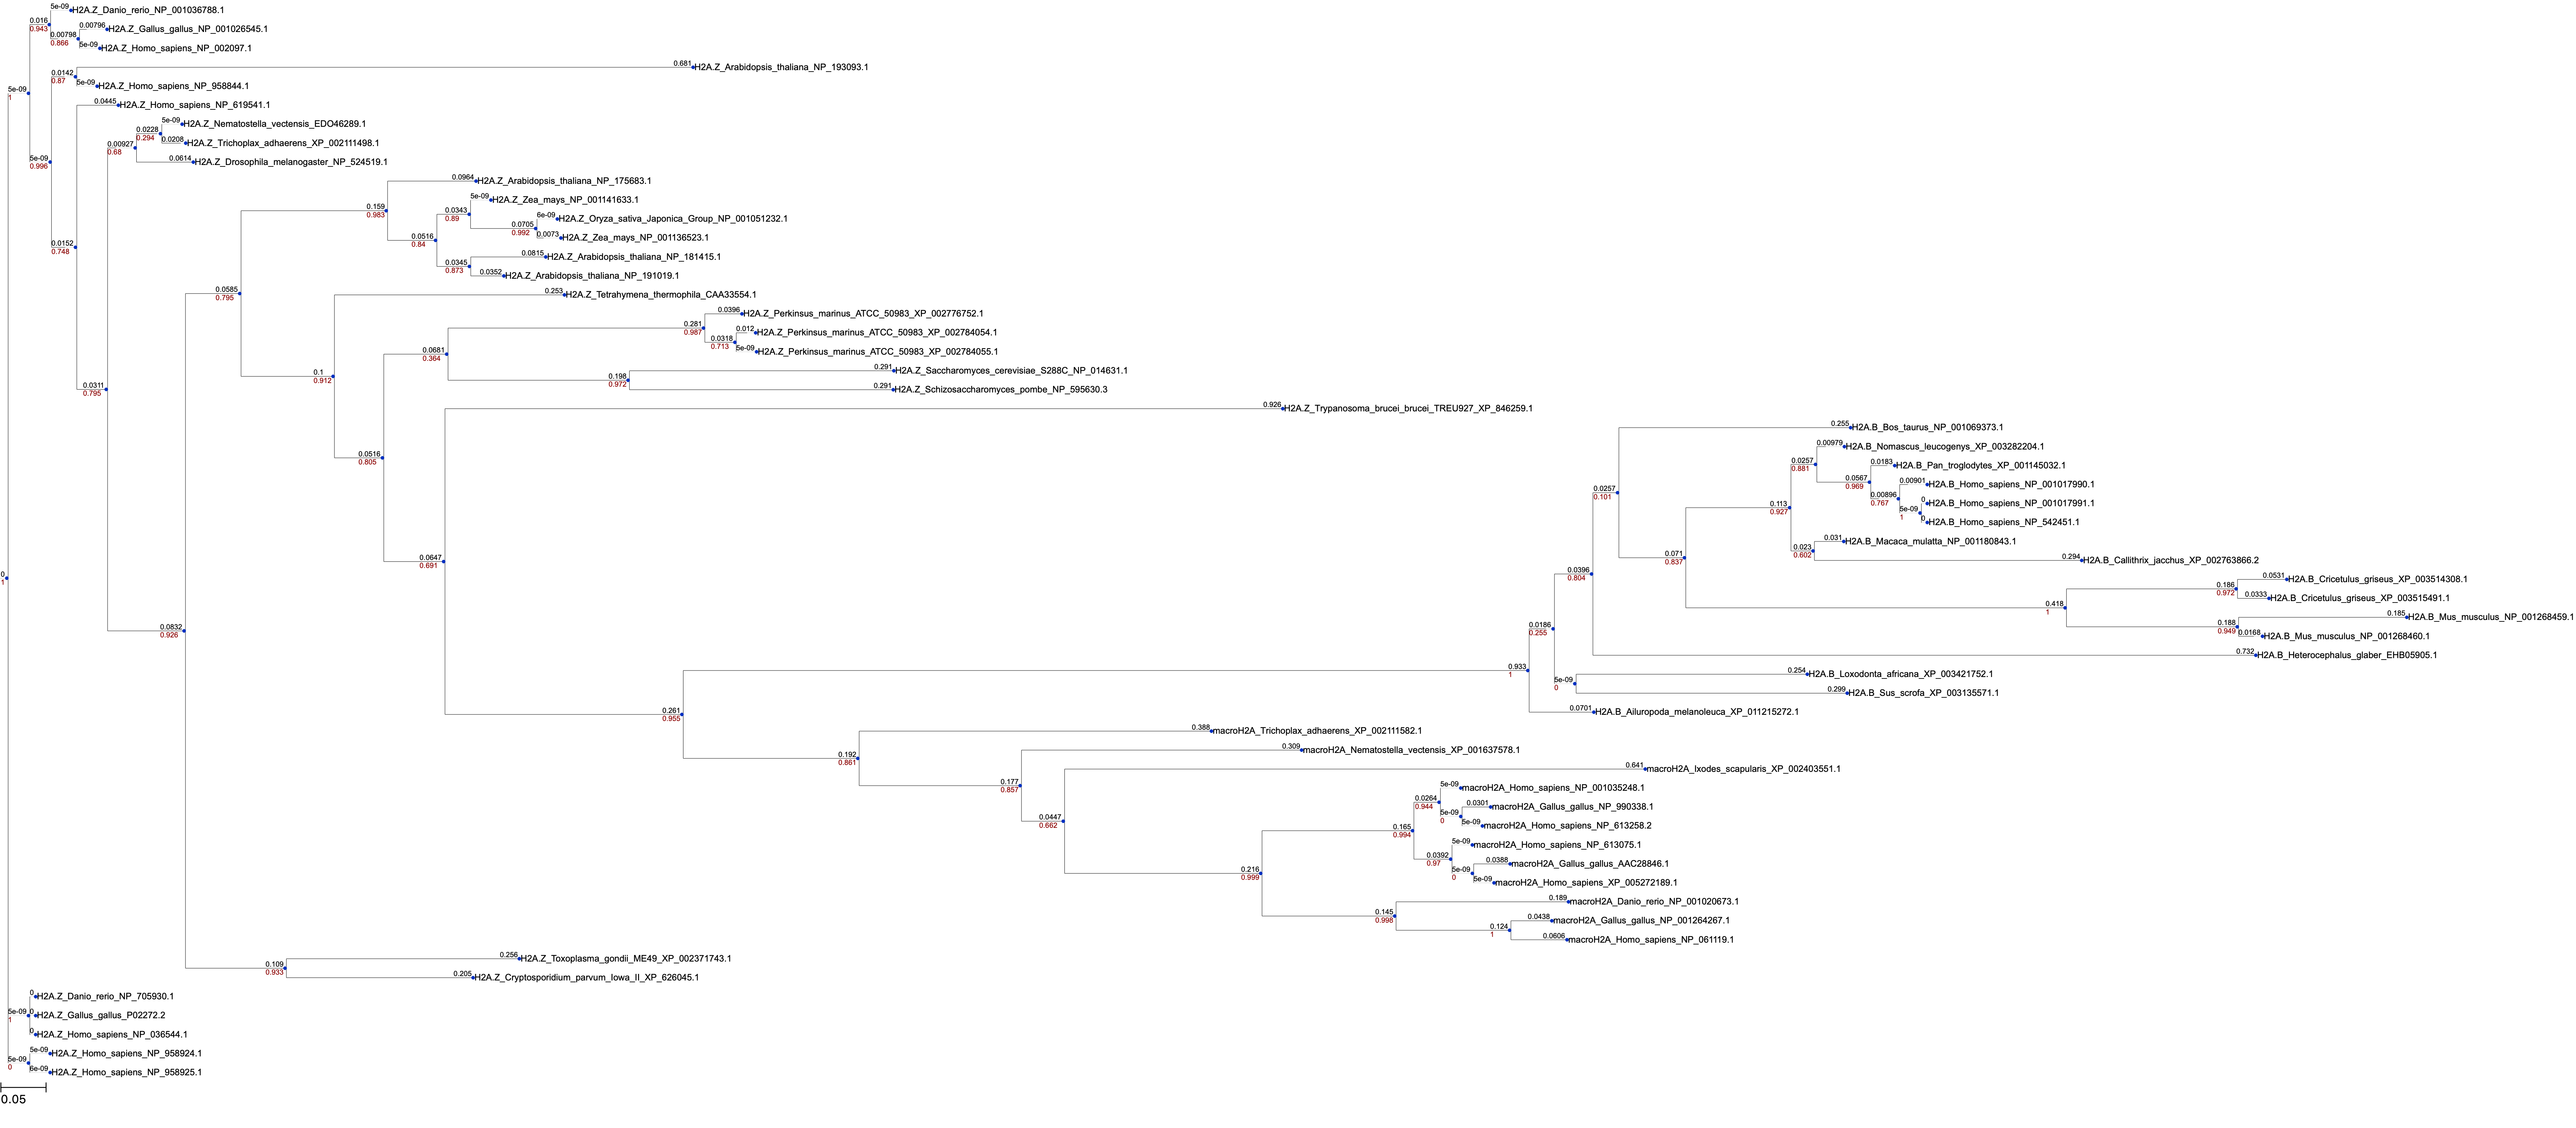

In [53]:
!FastTree < seeds/{name}.fasta > tmp/tree_file 2> /dev/null
t = Tree("tmp/tree_file")
ts = TreeStyle()
# style.mode = "c" # draw tree in circular mode
ts.scale = 1000
ts.show_leaf_name = True
ts.show_branch_length = True
ts.show_branch_support = True
t.render("%%inline", w=2000, units="mm", tree_style=ts)

## Export FastTree trees for viewing in the web pages to seeds

In [ ]:
#TODO

## Generate feature gff files for seeds

In [55]:
#Load curated seeds by traversing the tree
import os.path
curated_seeds_msa_form_files={}
for node in hist_tree.traverse("postorder"):
    if os.path.isfile(f"seeds/{node.name}.fasta"):
        print("Loading ",node.name)
        curated_seeds_msa_form_files[node.name] =   AlignIO.read(f"seeds/{node.name}.fasta", "fasta") if os.path.getsize(f"seeds/{node.name}.fasta") >0 else []

Loading  H2A.Z
Loading  H2A.B
Loading  macroH2A
Loading  H2A


In [58]:
for k,v in curated_seeds_msa_form_files.items():
    print(hist_features(SummaryInfo(v).dumb_consensus(threshold=0.1,ambiguous='X')))

[SeqFeature(FeatureLocation(ExactPosition(84), ExactPosition(192)), type='misc', id='inner_core'), SeqFeature(FeatureLocation(ExactPosition(84), ExactPosition(192)), type='misc', id='core'), SeqFeature(FeatureLocation(ExactPosition(84), ExactPosition(91)), type='helix', id='alpha1ext'), SeqFeature(FeatureLocation(ExactPosition(94), ExactPosition(106)), type='helix', id='alpha1'), SeqFeature(FeatureLocation(ExactPosition(115), ExactPosition(143)), type='helix', id='alpha2'), SeqFeature(FeatureLocation(ExactPosition(148), ExactPosition(159)), type='helix', id='alpha3'), SeqFeature(FeatureLocation(ExactPosition(159), ExactPosition(167)), type='misc', id='alpha3ext'), SeqFeature(FeatureLocation(ExactPosition(106), ExactPosition(115)), type='loop', id='loopL1'), SeqFeature(FeatureLocation(ExactPosition(143), ExactPosition(148)), type='loop', id='loopL2'), SeqFeature(FeatureLocation(ExactPosition(111), ExactPosition(113)), type='sheet', id='beta1'), SeqFeature(FeatureLocation(ExactPosition(1

### generate core seeds from seeds

In [11]:
#Make Analyze core seeds
!mkdir -p seeds_core

In [12]:
msa = AlignIO.read(f"seeds/{name}.fasta", "fasta")
f=hist_features(SummaryInfo(msa).dumb_consensus(threshold=0.1,ambiguous='X'))
ftsh=hist_shf4seq(SummaryInfo(msa).dumb_consensus(threshold=0.1,ambiguous='X'))

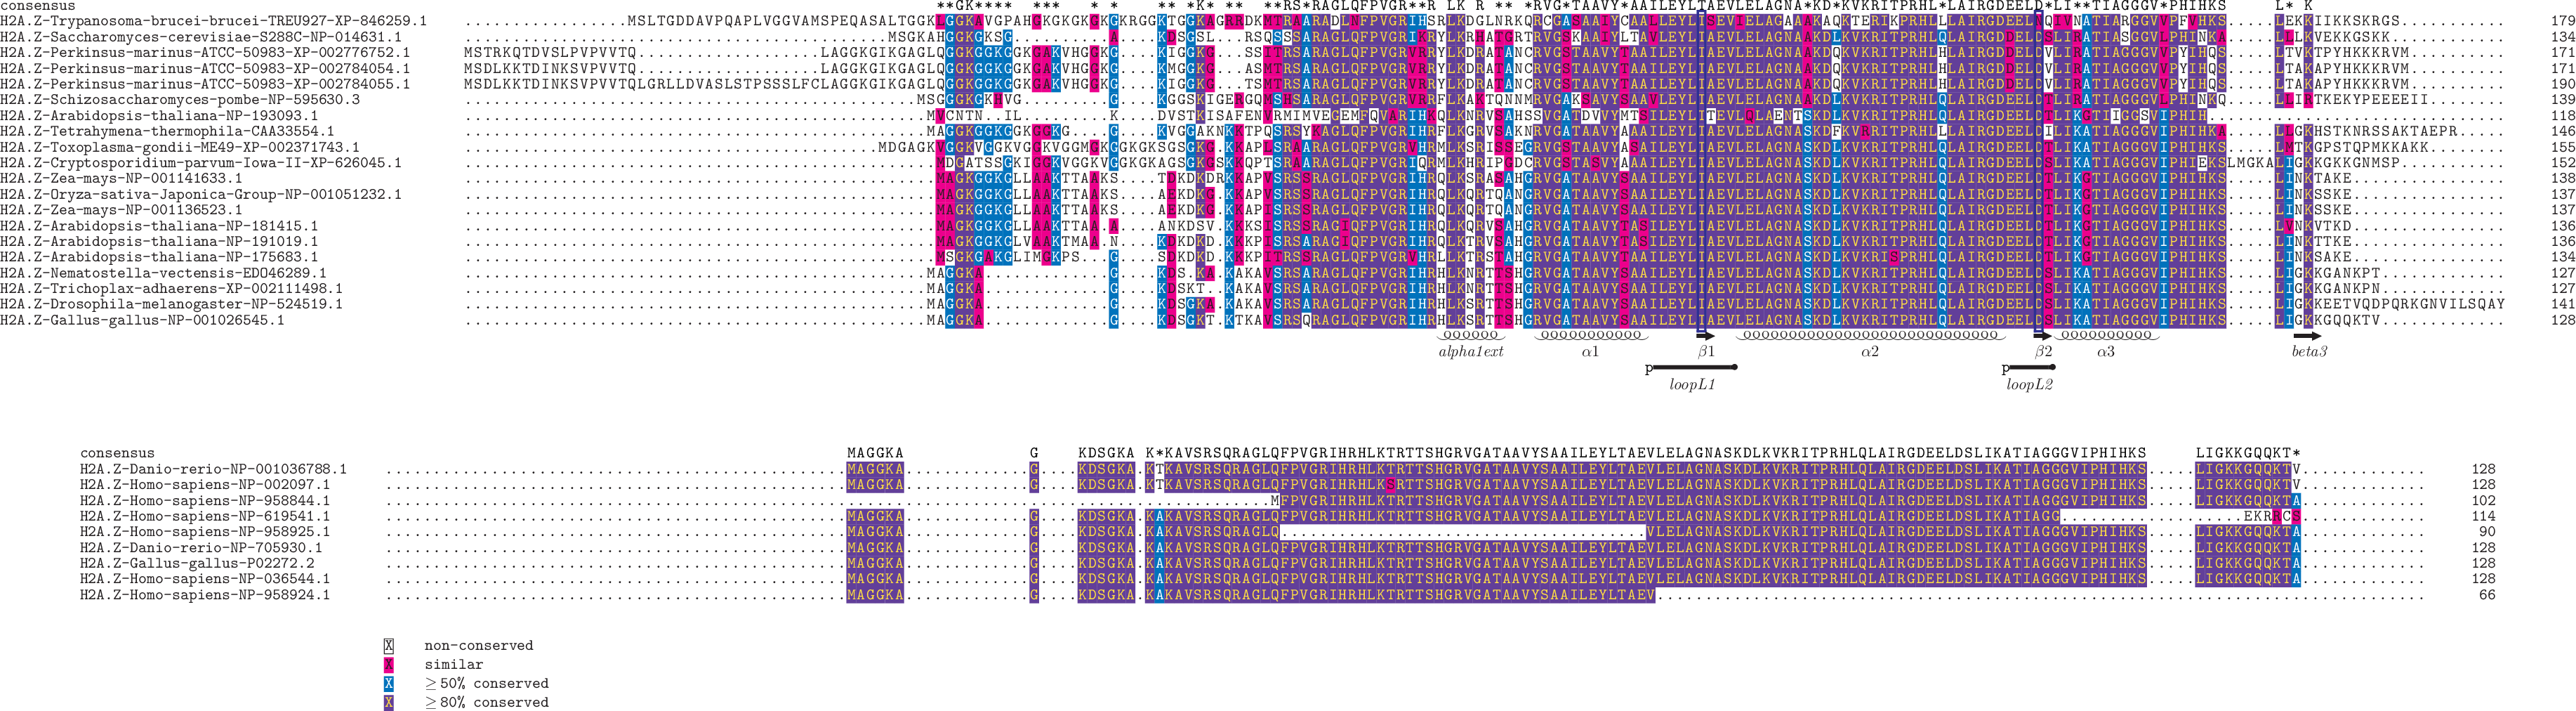

In [13]:
ipyshade.shadedmsa(msa,features=ftsh)

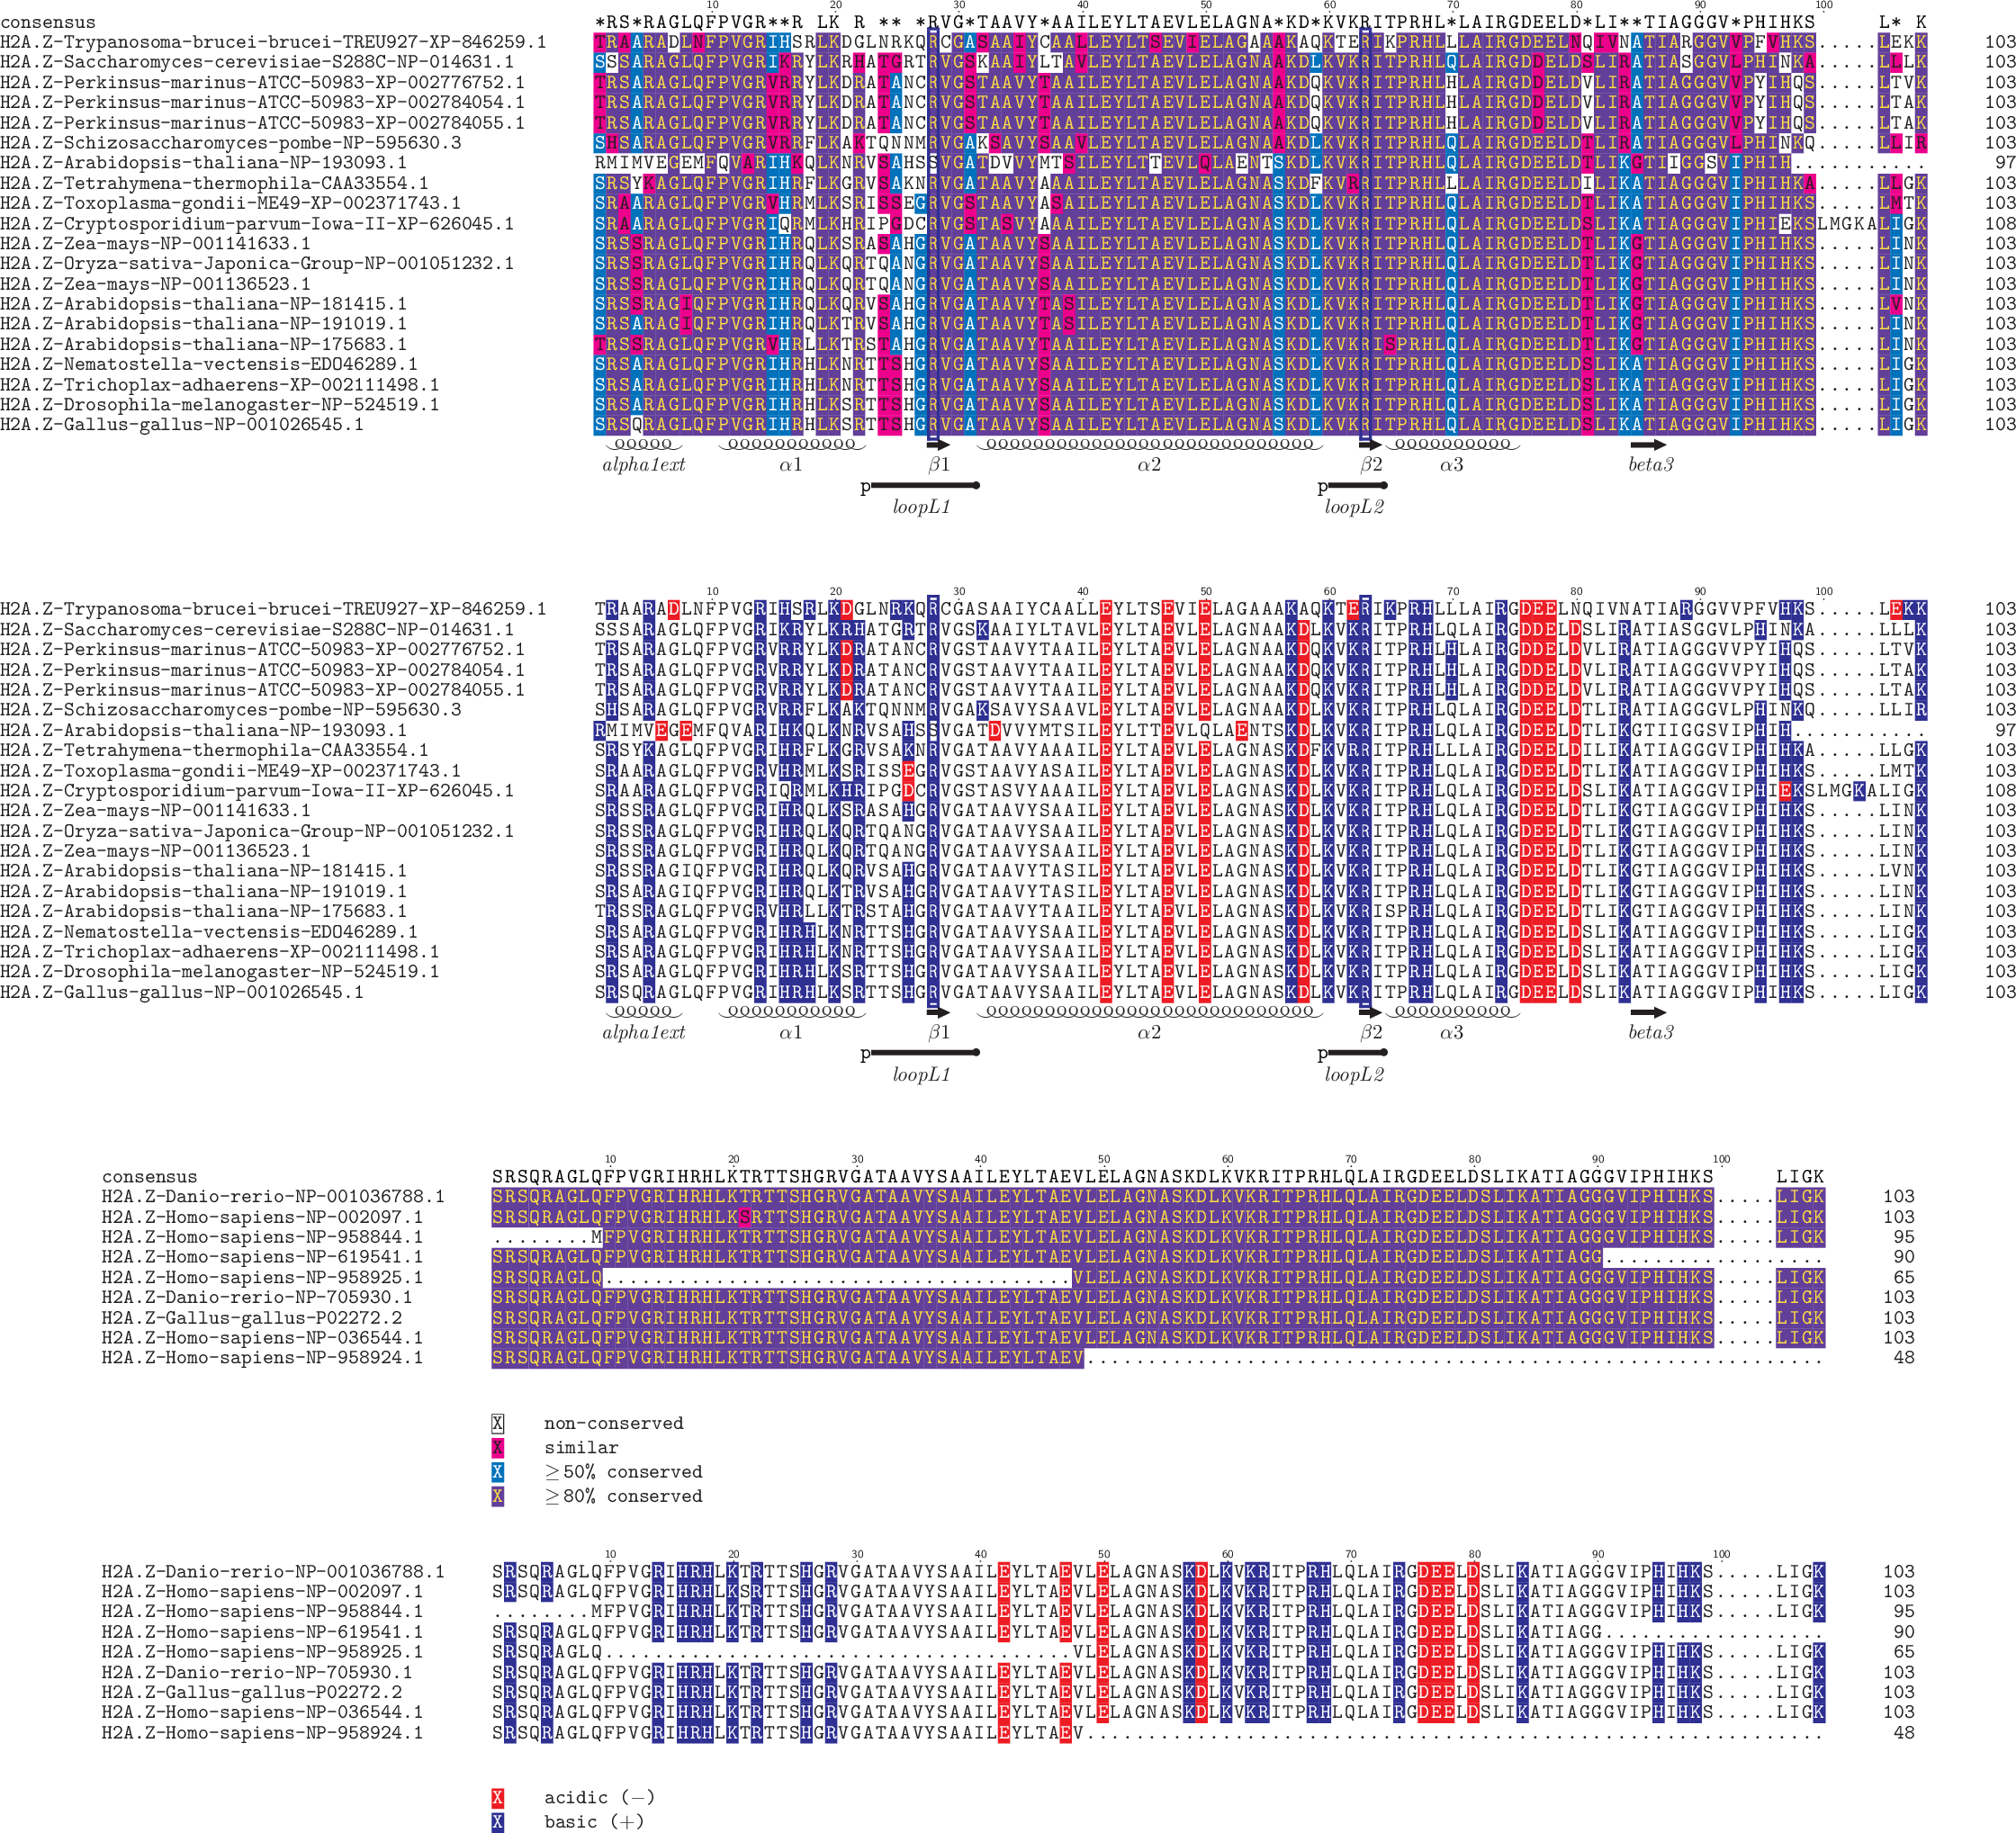

In [16]:
core=hist_features(SummaryInfo(msa).dumb_consensus(threshold=0.1,ambiguous='X'))[1]
msa_core=msa[:,core.location.start:core.location.end]
ipyshade.shadedmsa(msa_core,shading_modes=['similar','charge_functional'],ruler=True,features=hist_shf4seq(SummaryInfo(msa_core).dumb_consensus(threshold=0.1,ambiguous='X')))

In [17]:
with open(f'seeds_core/{name}.fasta','w') as f:
    f.write(msa_core.format('fasta'))

# Create html pages for browsing curated aligments

In [18]:
!mkdir -p html

## tree with phylocanvas.gl
- current problems - cannot draw internal nodes as glyphs
- cannot make nodes clickable

In [100]:
p="""
<html>
<h1> Classification tree of histones and their variants used in HistoneDB</h1>
<h3>Click on node to view sequence alignment</h3>
<div id="demo">
</div>
<script src="https://unpkg.com/@phylocanvas/phylocanvas.gl@latest/dist/bundle.min.js"></script>
<script>
  const tree = new phylocanvas.PhylocanvasGL(
  document.querySelector("#demo"),
    {
    styles: {
      // set colour, default shape and label
      H3: { fillColour: "blue" },
      H4: { fillColour: "green" },
      H2A: { fillColour: "yellow" },
      H2B: { fillColour: "red" },
      },
    interactive: true,
        showLabels: true,
        showLeafLabels: true,
        showInternalLabels: true,
        //collapsedIds: ["H2A"],
      size: { width: 600, height: 400 },
      source: `%s`,
      type: phylocanvas.TreeTypes.Rectangular,
    },
  );
   //tree.collapseNode("1");
</script>
</html>
"""%hist_tree.write(format=1)
with open('html/tree_phylogl.html','w') as t:
    t.write(p)

### tree with phylocanvas
- current problems - cannot  even label internal nodes
- cannot make nodes clickable


In [101]:
p="""
<!DOCTYPE html>
<html>
<head>
  <style>
    body {
      margin: 0.625em auto;
      max-width: 60em;
    }
    #phylocanvas {
      width: 100%%;
      height: 30em;
    }
  </style>
</head>
<body>
  <h1>Phylocanvas Quickstart</h1>
  <div id="phylocanvas"></div>
  <script type="application/javascript" src="http://cdn.rawgit.com/phylocanvas/phylocanvas-quickstart/v2.8.1/phylocanvas-quickstart.js"></script>
  <script type="application/javascript">
    (function (Phylocanvas) {
      var tree = Phylocanvas.createTree('phylocanvas');
      tree.load('%s');
      tree.setTreeType('rectangular');
      tree.displayLabels();
      tree.displayInternalLabels();
      tree.branches['pcn3'].collapsed = true;
    })(window.Phylocanvas);
  </script>
</body>
</html>
"""%hist_tree.write(format=1)
with open('html/tree_phylo.html','w') as t:
    t.write(p)

### So currently we will stick with pure JS solution using D3
see html/tree_d3.html